In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error ,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import shap
import xgboost
shap.initjs()

In [3]:
#データ読み込み
data = pd.read_csv("./data/train.csv")

In [4]:
def data_craft(data,onehot: list = [],delete:list =[], normal:str ="n" or "y"):
    #onehot = [onehotdしたいカラムをリスト型で記入、元のカラムは消えます] デフォルトは[]
    if len(onehot) > 0:
        for i in onehot:
            oh_data = pd.get_dummies(data.loc[:,i],prefix=i)
            data = pd.concat([data,oh_data],axis=1)
            data = data.drop(i,axis=1)
    
    #delete = [消したいカラムをリスト型で記入]、デフォルトは[]
    if len(delete) > 0:
        for i in delete:
            data = data.drop(i,axis=1)
            
    #X,Y作成
    X = data.drop("HeartDisease",axis=1)
    Y = data["HeartDisease"]
    
    return X,Y

In [5]:
def data_normal(data):
#normalize normal == yで標準化
    data["Cholesterol"] = data["Cholesterol"].replace([0],np.nan)
    stdsc = StandardScaler()
    stdsc.fit(data)
    sc_data = stdsc.transform(data)
    data = pd.DataFrame(sc_data,columns=data.columns.values)
    
    #k近傍補完
    
    data["Cholesterol"] = KNNImputer(n_neighbors=len(data.columns)).fit_transform(data)[:,3]
    
    return data

In [6]:

X,Y = data_craft(data,onehot=["ChestPainType","RestingECG","ST_Slope"])

In [7]:
X["ST_Slope_Down+Flat"]=X["ST_Slope_Down"]+X["ST_Slope_Flat"]

In [8]:
X["ASY×FastingBS"] = X["ChestPainType_ASY"] * X["FastingBS"]


In [9]:
X = data_normal(X)

In [10]:
pipelines = {
    'tree': 
        Pipeline([('scl',StandardScaler()), 
                  ('est',DecisionTreeClassifier(random_state=123))]), 

    'rf': 
        Pipeline([('scl',StandardScaler()), 
                  ('est',RandomForestClassifier(min_samples_leaf=7,random_state=123))]), 
    'gb': 
        Pipeline([('scl',StandardScaler()), 
                  ('est',GradientBoostingClassifier(random_state=123))]), 
}

In [11]:
scores = {}
shap_values = {}
explainers = {}
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=123)

for pipe_name, pipeline in pipelines.items(): 
    pipeline.fit(X_train, Y_train) 
    print(type(Y_train), type(X_train))
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train)) 
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train)
    
pd.Series(scores).unstack()

<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


test     train
gb    0.829016  0.988864
rf    0.844560  0.899777
tree  0.756477  1.000000

In [12]:
# shap.summary_plot(shap_values["rf"], X, plot_type="bar")

In [13]:
# shap.summary_plot(shap_values["gb"], X, plot_type="bar")

In [14]:
column1 = ["Age",
           "Sex",
           "RestingBP",
           "Cholesterol",
           "FastingBS",
           "MaxHR",
           "ExerciseAngina",
           "Oldpeak",
           "ChestPainType_ASY",
           "ChestPainType_ATA",
           "ChestPainType_NAP",
           "ChestPainType_TA",
           "RestingECG_LVH",
           "RestingECG_Normal",
           "RestingECG_ST",
           "ST_Slope_Down",
           "ST_Slope_Flat",
           "ST_Slope_Up",
           "ST_Slope_Down+Flat",
           "ASY×FastingBS"]

# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column1], plot_type="bar")

In [15]:
column1_1 = ["Age",
           "Sex",
           "RestingBP",
           "Cholesterol",
           "FastingBS",
           "MaxHR",
           "ExerciseAngina",
           "Oldpeak",
           "ChestPainType_ASY",
           "ChestPainType_ATA",
           "ChestPainType_NAP",
           "ChestPainType_TA",
           "RestingECG_LVH",
           "RestingECG_Normal",
           "RestingECG_ST",
           "ST_Slope_Down",
           "ST_Slope_Flat",
           "ST_Slope_Up"
           #"ST_Slope_Down+Flat",
           #"ASY×FastingBS"
            ]


In [16]:
scores = {} 
shap_values = {}
explainers = {}
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=123) 

for pipe_name, pipeline in pipelines.items(): 
    pipeline.fit(X_train[column1_1], Y_train) 
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column1_1])) 
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column1_1]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column1_1])
    
pd.Series(scores).unstack()

test     train
gb    0.839378  0.986637
rf    0.844560  0.904232
tree  0.761658  1.000000

In [17]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column1_1], plot_type="bar")

In [18]:
test = pd.get_dummies(data)
print(len(test.columns))
test.columns


19


Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

# コード回してみた（"ST_Slope_Down","ST_Slope_Flat",の削除）

In [19]:
column2 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        "ChestPainType_ASY",
        "ChestPainType_ATA",
        "ChestPainType_NAP",
        "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        # "ST_Slope_Down",
        # "ST_Slope_Flat",
        "ST_Slope_Up",
        #"ST_Slope_Down+Flat",
        #"ASY×FastingBS"
]


In [20]:
scores = {} 
shap_values = {}
explainers = {}



for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column2], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column2]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column2]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train)
pd.Series(scores).unstack()

test     train
gb    0.829016  0.984410
rf    0.834197  0.906459
tree  0.777202  1.000000

In [21]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column1], plot_type="bar")

In [22]:
column2_1 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        "ChestPainType_ASY",
        "ChestPainType_ATA",
        "ChestPainType_NAP",
        "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        # "ST_Slope_Down",
        # "ST_Slope_Flat",
        "ST_Slope_Up",
        "ST_Slope_Down+Flat",
        #"ASY×FastingBS"
]


In [23]:
scores = {} 
shap_values = {}
explainers = {}



for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column2_1], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column2_1]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column2_1]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column2_1])
pd.Series(scores).unstack()

test     train
gb    0.829016  0.984410
rf    0.823834  0.906459
tree  0.725389  1.000000

In [24]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column2_1], plot_type="bar")

# コードを掛け合わせる

In [25]:
column3 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        "ST_Slope_Down",
        "ST_Slope_Flat",
        "ST_Slope_Up",
        #"ST_Slope_Down+Flat",
        "ASY×FastingBS"
]


In [26]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}



for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column3], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column3]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column3]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column3])
pd.Series(scores).unstack()

test     train
gb    0.818653  0.986637
rf    0.839378  0.906459
tree  0.772021  1.000000

In [27]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column3], plot_type="bar")

In [28]:
column3_1 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
       #"ST_Slope_Down+Flat",
        "ASY×FastingBS"
]


In [29]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}


for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column3_1], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column3_1]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column3_1]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column3_1])
pd.Series(scores).unstack()



test     train
gb    0.813472  0.988864
rf    0.813472  0.910913
tree  0.746114  1.000000

In [30]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column3_1], plot_type="bar")

In [31]:
column3_2 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        "ST_Slope_Down+Flat"
]


In [32]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}


for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column3_2], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column3_2]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column3_2]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column3_2])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.988864
rf    0.844560  0.897550
tree  0.751295  1.000000

In [33]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column3_2], plot_type="bar")

# shapから削る

In [34]:
column4 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        # "ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        "ST_Slope_Down+Flat"
       
]


In [35]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column4], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column4]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column4]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column4])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.988864
rf    0.844560  0.899777
tree  0.761658  1.000000

In [36]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column4], plot_type="bar")

In [37]:
column4_1 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        #"RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        "ST_Slope_Down+Flat"
]


In [38]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}


for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column4_1], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column4_1]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column4_1]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column4_1])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.988864
rf    0.844560  0.899777
tree  0.761658  1.000000

In [39]:
# for name,shap_value in salhap_values.items():
#     shap.summary_plot(shap_vue, X_train[column4_1], plot_type="bar")

In [40]:
column4_2 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        #"RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        "ST_Slope_Down+Flat"
]


In [41]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}


for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column4_2], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column4_2]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column4_2]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column4_2])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.988864
rf    0.844560  0.899777
tree  0.761658  1.000000

In [42]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column4_2], plot_type="bar")

- 変相関係数を見る

In [43]:
# ↓ソース
# 変相関係数
# https://qiita.com/Herios/items/ecd14ec273e740fa08d5

def df_partial_corr(df):
    temp_cov = df.cov()
    omega = np.linalg.inv(temp_cov)
    D = np.diag(np.power(np.diag(omega), -0.5))
    temp_pcorr = -np.dot(np.dot(D, omega), D) \
                         + 2*np.eye(temp_cov.shape[0])
    mtx_pcorr = pd.DataFrame(temp_pcorr, 
                             columns = temp_cov.columns,
                             index = temp_cov.index)
    return mtx_pcorr

test = pd.get_dummies(data)

# df_partial_corr(test)[["RestingECG_Normal","RestingECG_LVH",]]


In [44]:
print(test.columns)
print(len(test.columns))

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')
19


- 相関が大きいカラムがなさそうなので削る

In [45]:
column5 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        #"RestingECG_LVH",
        #"RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        # "ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        #"ST_Slope_Down+Flat"
       
]


In [46]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}


for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column5], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column5]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column5]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column5])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.984410
rf    0.829016  0.910913
tree  0.761658  1.000000

In [47]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column5], plot_type="bar")

In [48]:
column5_1 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        #"RestingECG_LVH",
        #"RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        #"ST_Slope_Down+Flat"
]


In [49]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}


for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column5_1], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column5_1]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column5_1]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column5_1])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.984410
rf    0.829016  0.910913
tree  0.761658  1.000000

In [50]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column5_1], plot_type="bar")

In [51]:
column5_2 = [
        "Age",
        "Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        #"RestingECG_LVH",
        #"RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        "ST_Slope_Down+Flat"
]


In [52]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}



for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column5_2], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column5_2]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column5_2]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column5_2])
pd.Series(scores).unstack()

test     train
gb    0.813472  0.984410
rf    0.834197  0.902004
tree  0.735751  1.000000

In [53]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column5_2], plot_type="bar")

In [54]:
column6_1 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        # "RestingECG_LVH",
        # "RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        "ST_Slope_Down+Flat"
]


In [55]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}



for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column6_1], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column6_1]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column6_1]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column6_1])
pd.Series(scores).unstack()

test     train
gb    0.823834  0.977728
rf    0.854922  0.890869
tree  0.792746  1.000000

In [56]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column6_1], plot_type="bar")

In [57]:
column6_2 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        # "RestingECG_LVH",
        # "RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        #"ST_Slope_Down+Flat"
]


In [58]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}



for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column6_2], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column6_2]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column6_2]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column6_2])
pd.Series(scores).unstack()

test     train
gb    0.823834  0.977728
rf    0.839378  0.893096
tree  0.777202  1.000000

In [59]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column6_2], plot_type="bar")

In [60]:
column7 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS",
        #"ST_Slope_Down+Flat"
]

In [61]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column7], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column7]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column7]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column7])
pd.Series(scores).unstack()

test     train
gb    0.829016  0.979955
rf    0.839378  0.908686
tree  0.782383  1.000000

In [62]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column7], plot_type="bar")

In [63]:
column8 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        #"RestingECG_LVH",
        #"RestingECG_Normal",
        #"RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS"
]

In [64]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column8], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column8]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column8]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column8])
pd.Series(scores).unstack()

test     train
gb    0.823834  0.977728
rf    0.839378  0.893096
tree  0.777202  1.000000

In [65]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column8], plot_type="bar")

In [66]:
column9 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        #"RestingECG_LVH",
        "RestingECG_Normal",
        #"RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS"
]

In [67]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column9], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column9]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column9]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column9])
pd.Series(scores).unstack()

test     train
gb    0.834197  0.979955
rf    0.839378  0.899777
tree  0.772021  1.000000

In [68]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column9], plot_type="bar")

In [69]:
column10 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        #"RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS"
]

In [70]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column10], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column10]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column10]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column10])
pd.Series(scores).unstack()

test     train
gb    0.823834  0.977728
rf    0.839378  0.906459
tree  0.782383  1.000000

In [71]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column10], plot_type="bar")

In [72]:
column11 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        #"ST_Slope_Up",
        "ASY×FastingBS"
]

In [73]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column11], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column11]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column11]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column11])
pd.Series(scores).unstack()

test     train
gb    0.766839  0.953229
rf    0.766839  0.888641
tree  0.715026  1.000000

In [74]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column11], plot_type="bar")

In [75]:
column12 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        #"ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS"
]

In [76]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column12], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column12]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column12]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column12])
pd.Series(scores).unstack()

test     train
gb    0.792746  0.975501
rf    0.829016  0.897550
tree  0.777202  1.000000

In [77]:
# ランダムフォレストの可視化
# from sklearn import tree
# _ = tree.plot_tree(model_random.estimators_[0], feature_names=data_train.columns, filled=True)

In [78]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column12], plot_type="bar")

In [79]:
column13 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        #"MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        "RestingECG_LVH",
        "RestingECG_Normal",
        "RestingECG_ST",
        #"ST_Slope_Down",
        #"ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS"
]

In [80]:
from dtreeviz.trees import dtreeviz

# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column13], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column13]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column13]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column13])
pd.Series(scores).unstack()




test     train
gb    0.834197  0.968820
rf    0.844560  0.893096
tree  0.772021  1.000000

In [81]:
from dtreeviz.trees import dtreeviz


In [82]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column13], plot_type="bar")

In [83]:
column6 = [
        "Age",
        #"Sex",
        "RestingBP",
        "Cholesterol",
        # "FastingBS",
        "MaxHR",
        "ExerciseAngina",
        "Oldpeak",
        # "ChestPainType_ASY",
        # "ChestPainType_ATA",
        # "ChestPainType_NAP",
        # "ChestPainType_TA",
        # "RestingECG_LVH",
        # "RestingECG_Normal",
        # "RestingECG_ST",
        # "ST_Slope_Down",
        "ST_Slope_Flat",
        "ST_Slope_Up",
        "ASY×FastingBS"
]


In [84]:
# 初期値
scores = {} 
shap_values = {}
explainers = {}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train[column6], Y_train)
    scores[(pipe_name,'train')] = accuracy_score(Y_train, pipeline.predict(X_train[column6]))
    scores[(pipe_name,'test')] = accuracy_score(Y_test, pipeline.predict(X_test[column6]))
    explainers[pipe_name] = shap.TreeExplainer(model = pipeline["est"])
    shap_values[pipe_name] = explainers[pipe_name].shap_values(X_train[column6])
pd.Series(scores).unstack()

test     train
gb    0.829016  0.979955
rf    0.849741  0.888641
tree  0.782383  1.000000

In [85]:
# for name,shap_value in shap_values.items():
#     shap.summary_plot(shap_value, X_train[column6], plot_type="bar")

In [86]:
X_train 

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train[column6])

rm = RandomForestClassifier(min_samples_leaf=7,random_state=123)


rm = rm.fit(X_train_ss, Y_train)
rm.feature_importances_

array([0.05662094, 0.02834661, 0.04264395, 0.08214   , 0.13561657,
       0.16069505, 0.1230178 , 0.3236815 , 0.04723756])

In [87]:
X_train.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat',
       'ST_Slope_Up', 'ST_Slope_Down+Flat', 'ASY×FastingBS'],
      dtype='object')

In [88]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# get_dummies() した後のデータをコピー
kmeans_x = X_train_ss.copy()

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(kmeans_x)
cluster = kmeans.predict(kmeans_x)

X_train_copy = X_train.copy()

# dataframe にデータの列 
X_train_copy = X_train_copy.assign(cluster = cluster)
X_train_copy["cluster"] = X_train_copy["cluster"].astype("str")


# sns.pairplot(X_train_copy, hue="cluster")

plt.show()

In [89]:
column6_kmean = [
           "Age",
           "Sex",
           "RestingBP",
           "Cholesterol",
           "FastingBS",
           "MaxHR",
           "ExerciseAngina",
           "Oldpeak",
        #    "ChestPainType_ASY",
        #    "ChestPainType_ATA",
        #    "ChestPainType_NAP",
        #    "ChestPainType_TA",
        #    "RestingECG_LVH",
        #    "RestingECG_Normal",
        #    "RestingECG_ST",
           "ST_Slope_Down",
           "ST_Slope_Flat",
           "ST_Slope_Up",
           "ST_Slope_Down+Flat",
           "ASY×FastingBS",
           "Cholesterol_0",
        ]

In [90]:
column6_kmean_cluster = [
           "Age",
           "Sex",
           "RestingBP",
           "Cholesterol",
           "FastingBS",
           "MaxHR",
           "ExerciseAngina",
           "Oldpeak",
        #    "ChestPainType_ASY",
        #    "ChestPainType_ATA",
        #    "ChestPainType_NAP",
        #    "ChestPainType_TA",
        #    "RestingECG_LVH",
        #    "RestingECG_Normal",
        #    "RestingECG_ST",
         #   "ST_Slope_Down",
         #   "ST_Slope_Flat",
         #   "ST_Slope_Up",
           "ST_Slope_Down+Flat",
           "ASY×FastingBS",
           "Cholesterol_0",
           "cluster",
        ]

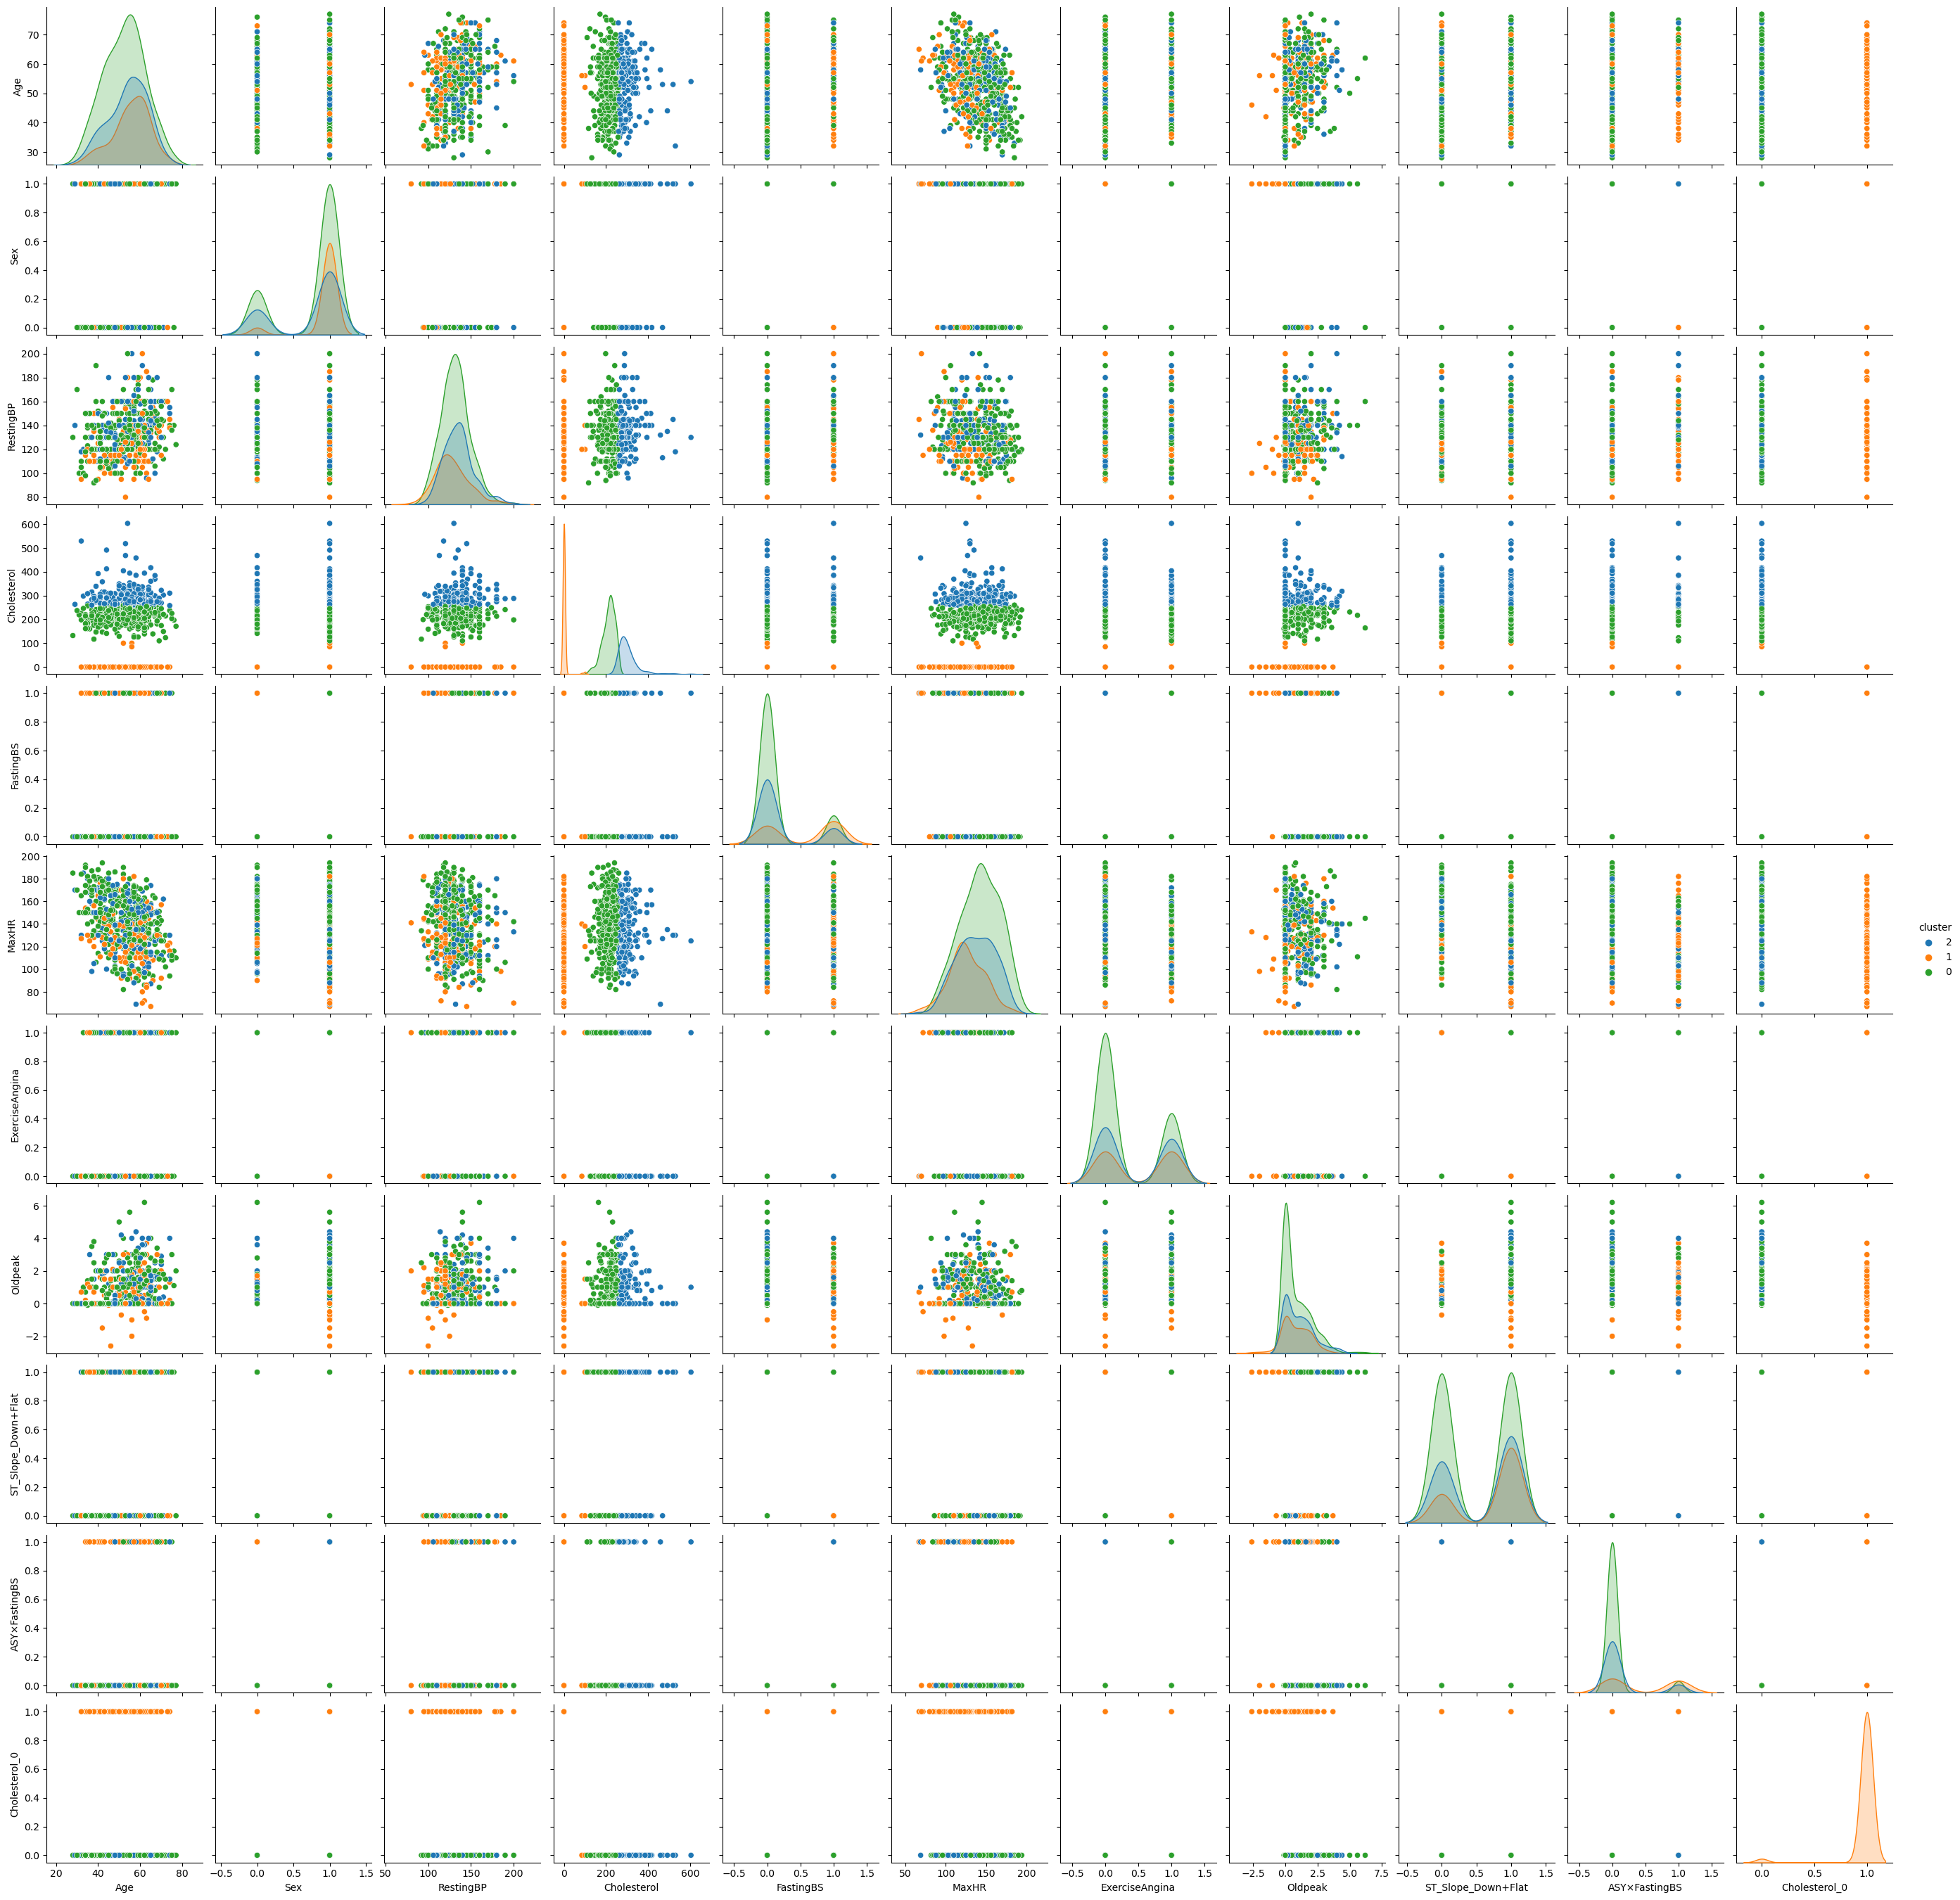

In [91]:
#データ読み込み
## Chrolestrol == 0 をカラムに追加
data = pd.read_csv("./exercises/data/train.csv")
data_copy2 = data.copy()

# カラムの作製
data_copy2 = pd.get_dummies(data_copy2)
data_copy2["ASY×FastingBS"]      = data_copy2["ChestPainType_ASY"] * data_copy2["FastingBS"]
data_copy2["ST_Slope_Down+Flat"] = data_copy2["ST_Slope_Down"] + data_copy2["ST_Slope_Flat"]    
data_copy2["Cholesterol_0"] = data_copy2["Cholesterol"].copy()
# コレステロール0フラグ
data_copy2.loc[data_copy2["Cholesterol_0"] == 0, "Cholesterol_0"] = -1
data_copy2.loc[data_copy2["Cholesterol_0"] != -1, "Cholesterol_0"] = 0
data_copy2.loc[data_copy2["Cholesterol_0"] == -1, "Cholesterol_0"] = 1

    # whereでも置き換えはできるらしい　まだ、実装できていない
    # data_copy2["Cholesterol_0"].where(data_copy2["Cholesterol_0"] == 0, 1)
    # data_copy2["Cholesterol_0"].where(data_copy2["Cholesterol_0"] != 0, 0)



# # 正規化 いらない？
# ss = StandardScaler()
# data_copy2_ss = ss.fit_transform(data_copy2)

km = KMeans(n_clusters = 3)
km.fit(data_copy2[column6_kmean])

# # cluster カラムの追加
cluster = km.predict(data_copy2[column6_kmean])
data_copy2 = data_copy2.assign(cluster = cluster)
data_copy2["cluster"] = data_copy2["cluster"].astype("str")

sns.pairplot(data_copy2[column6_kmean_cluster], hue="cluster")
plt.show()


In [92]:
data_copy2[column6_kmean_cluster]

Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0     56    1        155          342          1    150               1   
1     55    0        130          394          0    150               0   
2     47    1        110            0          1    120               1   
3     34    1        115            0          1    154               0   
4     54    0        160          201          0    163               0   
..   ...  ...        ...          ...        ...    ...             ...   
637   48    1        106          263          1    110               0   
638   53    1        126            0          0    106               0   
639   54    1        200          198          0    142               1   
640   45    0        130          237          0    170               0   
641   55    1        136          245          1    131               1   

     Oldpeak  ST_Slope_Down+Flat  ASY×FastingBS  Cholesterol_0 cluster  
0        3.0                   1              1              0       2  
1        0.0                   0              0              0       2  
2        0.0                   1              0              1       1  
3        0.2                   0              1              1       1  
4        0.0                   0              0              0       0  
..       ...                 ...            ...            ...     ...  
637      0.0                   1              1              0       2  
638      0.0                   1              0              1       1  
639      2.0                   1              0              0       0  
640      0.0                   0              0              0       0  
641      1.2                   1              0              0       0  

[642 rows x 12 columns]

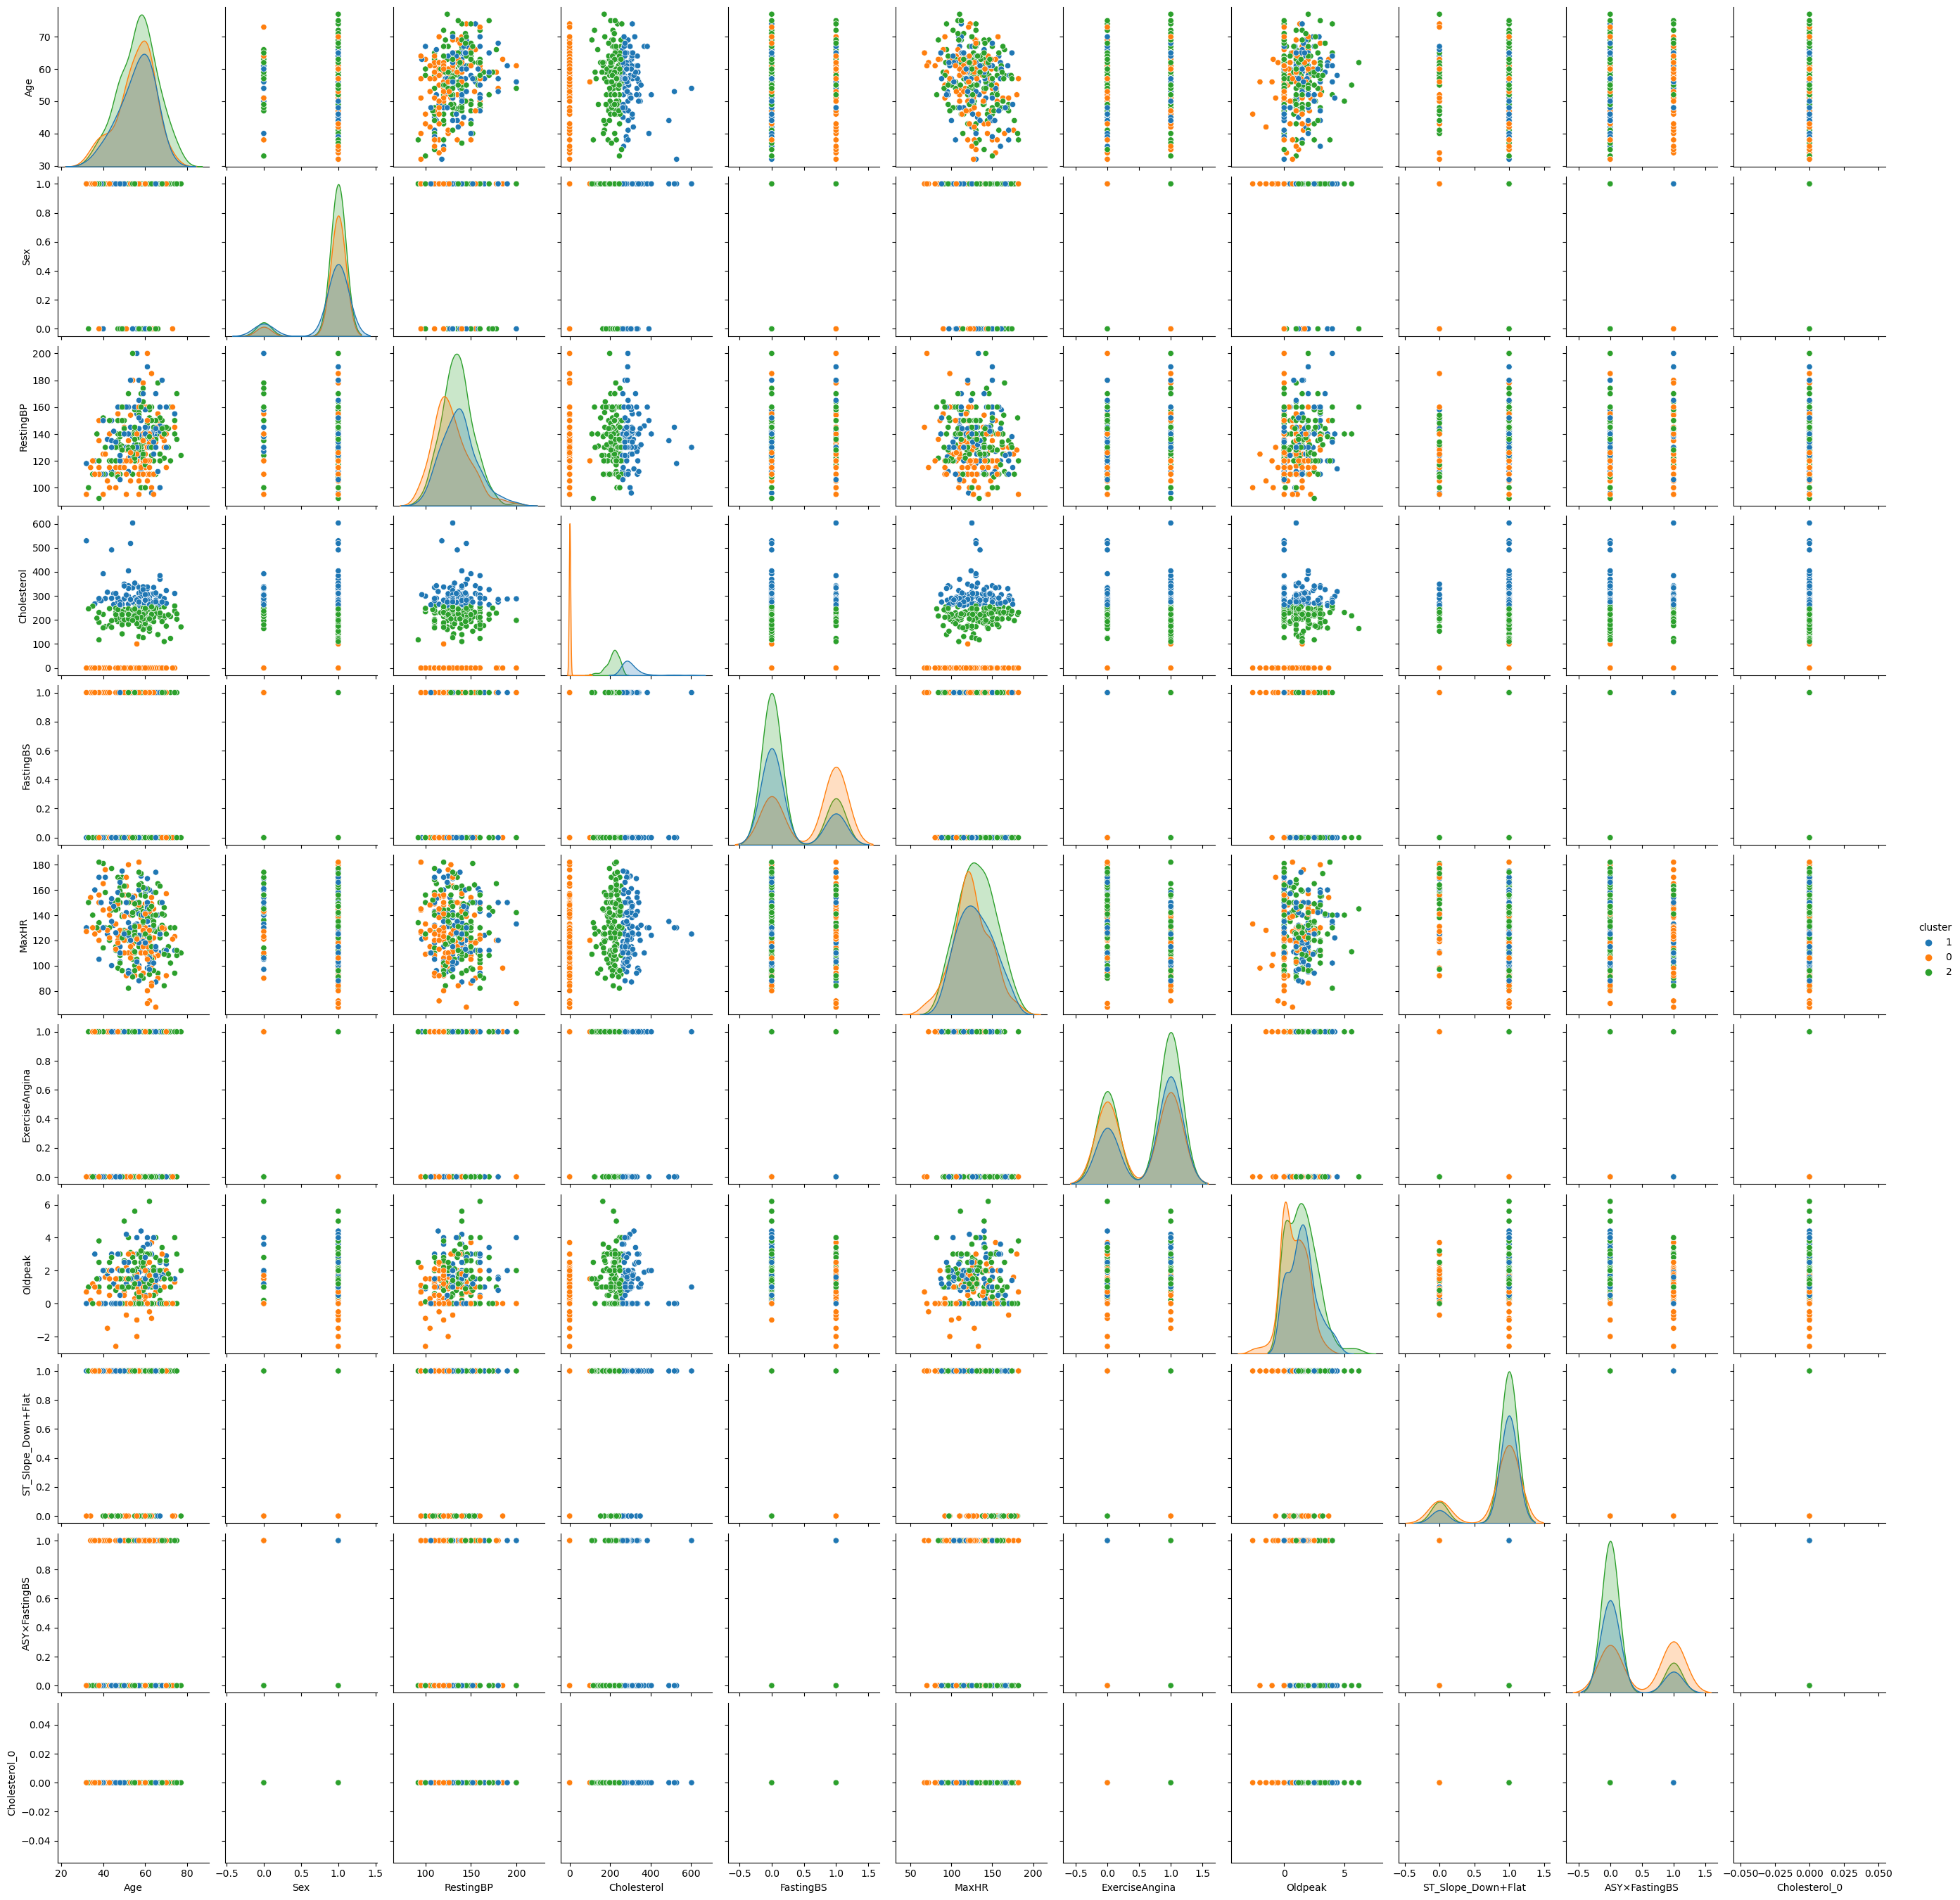

In [93]:
## Chrolestrol == 0 をカラムに追加、 HeartDisease == 1 のみに絞る
data_copy3 = data.copy()
data_copy3 = pd.get_dummies(data_copy3)

data_copy3["ASY×FastingBS"]      = data_copy3["ChestPainType_ASY"] * data_copy3["FastingBS"]
data_copy3["ST_Slope_Down+Flat"] = data_copy3["ST_Slope_Down"] + data_copy3["ST_Slope_Flat"]    

data_copy3["Cholesterol_0"] = data_copy3["Cholesterol"].copy()
data_copy3.loc[data_copy3["Cholesterol_0"] == 0, "Cholesterol_0"] = -1 
data_copy3.loc[data_copy3["Cholesterol_0"] != -1, "Cholesterol_0"] = 0
data_copy3.loc[data_copy3["Cholesterol_0"] == -1, "Cholesterol_0"] = 1
data_copy3.head()

km = KMeans(n_clusters = 3)
km.fit(data_copy3.loc[data_copy2["HeartDisease"] == 1])


cluster = km.predict(data_copy3.loc[data_copy2["HeartDisease"] == 1])
data_copy3_heardisease_1 = data_copy3.loc[data_copy2["HeartDisease"] == 1]

data_copy3_heardisease_1 = data_copy3_heardisease_1.assign(cluster = cluster)
data_copy3_heardisease_1["cluster"] = data_copy3_heardisease_1["cluster"].astype("str")

sns.pairplot(data_copy3_heardisease_1[column6_kmean_cluster], hue="cluster")
plt.show()
# # print(len(data_copy3_drop), len(cluster))
# data_copy3_drop.head()


In [97]:
data_copy3_heardisease_1["Cholesterol_0"].unique()

array([0], dtype=int64)

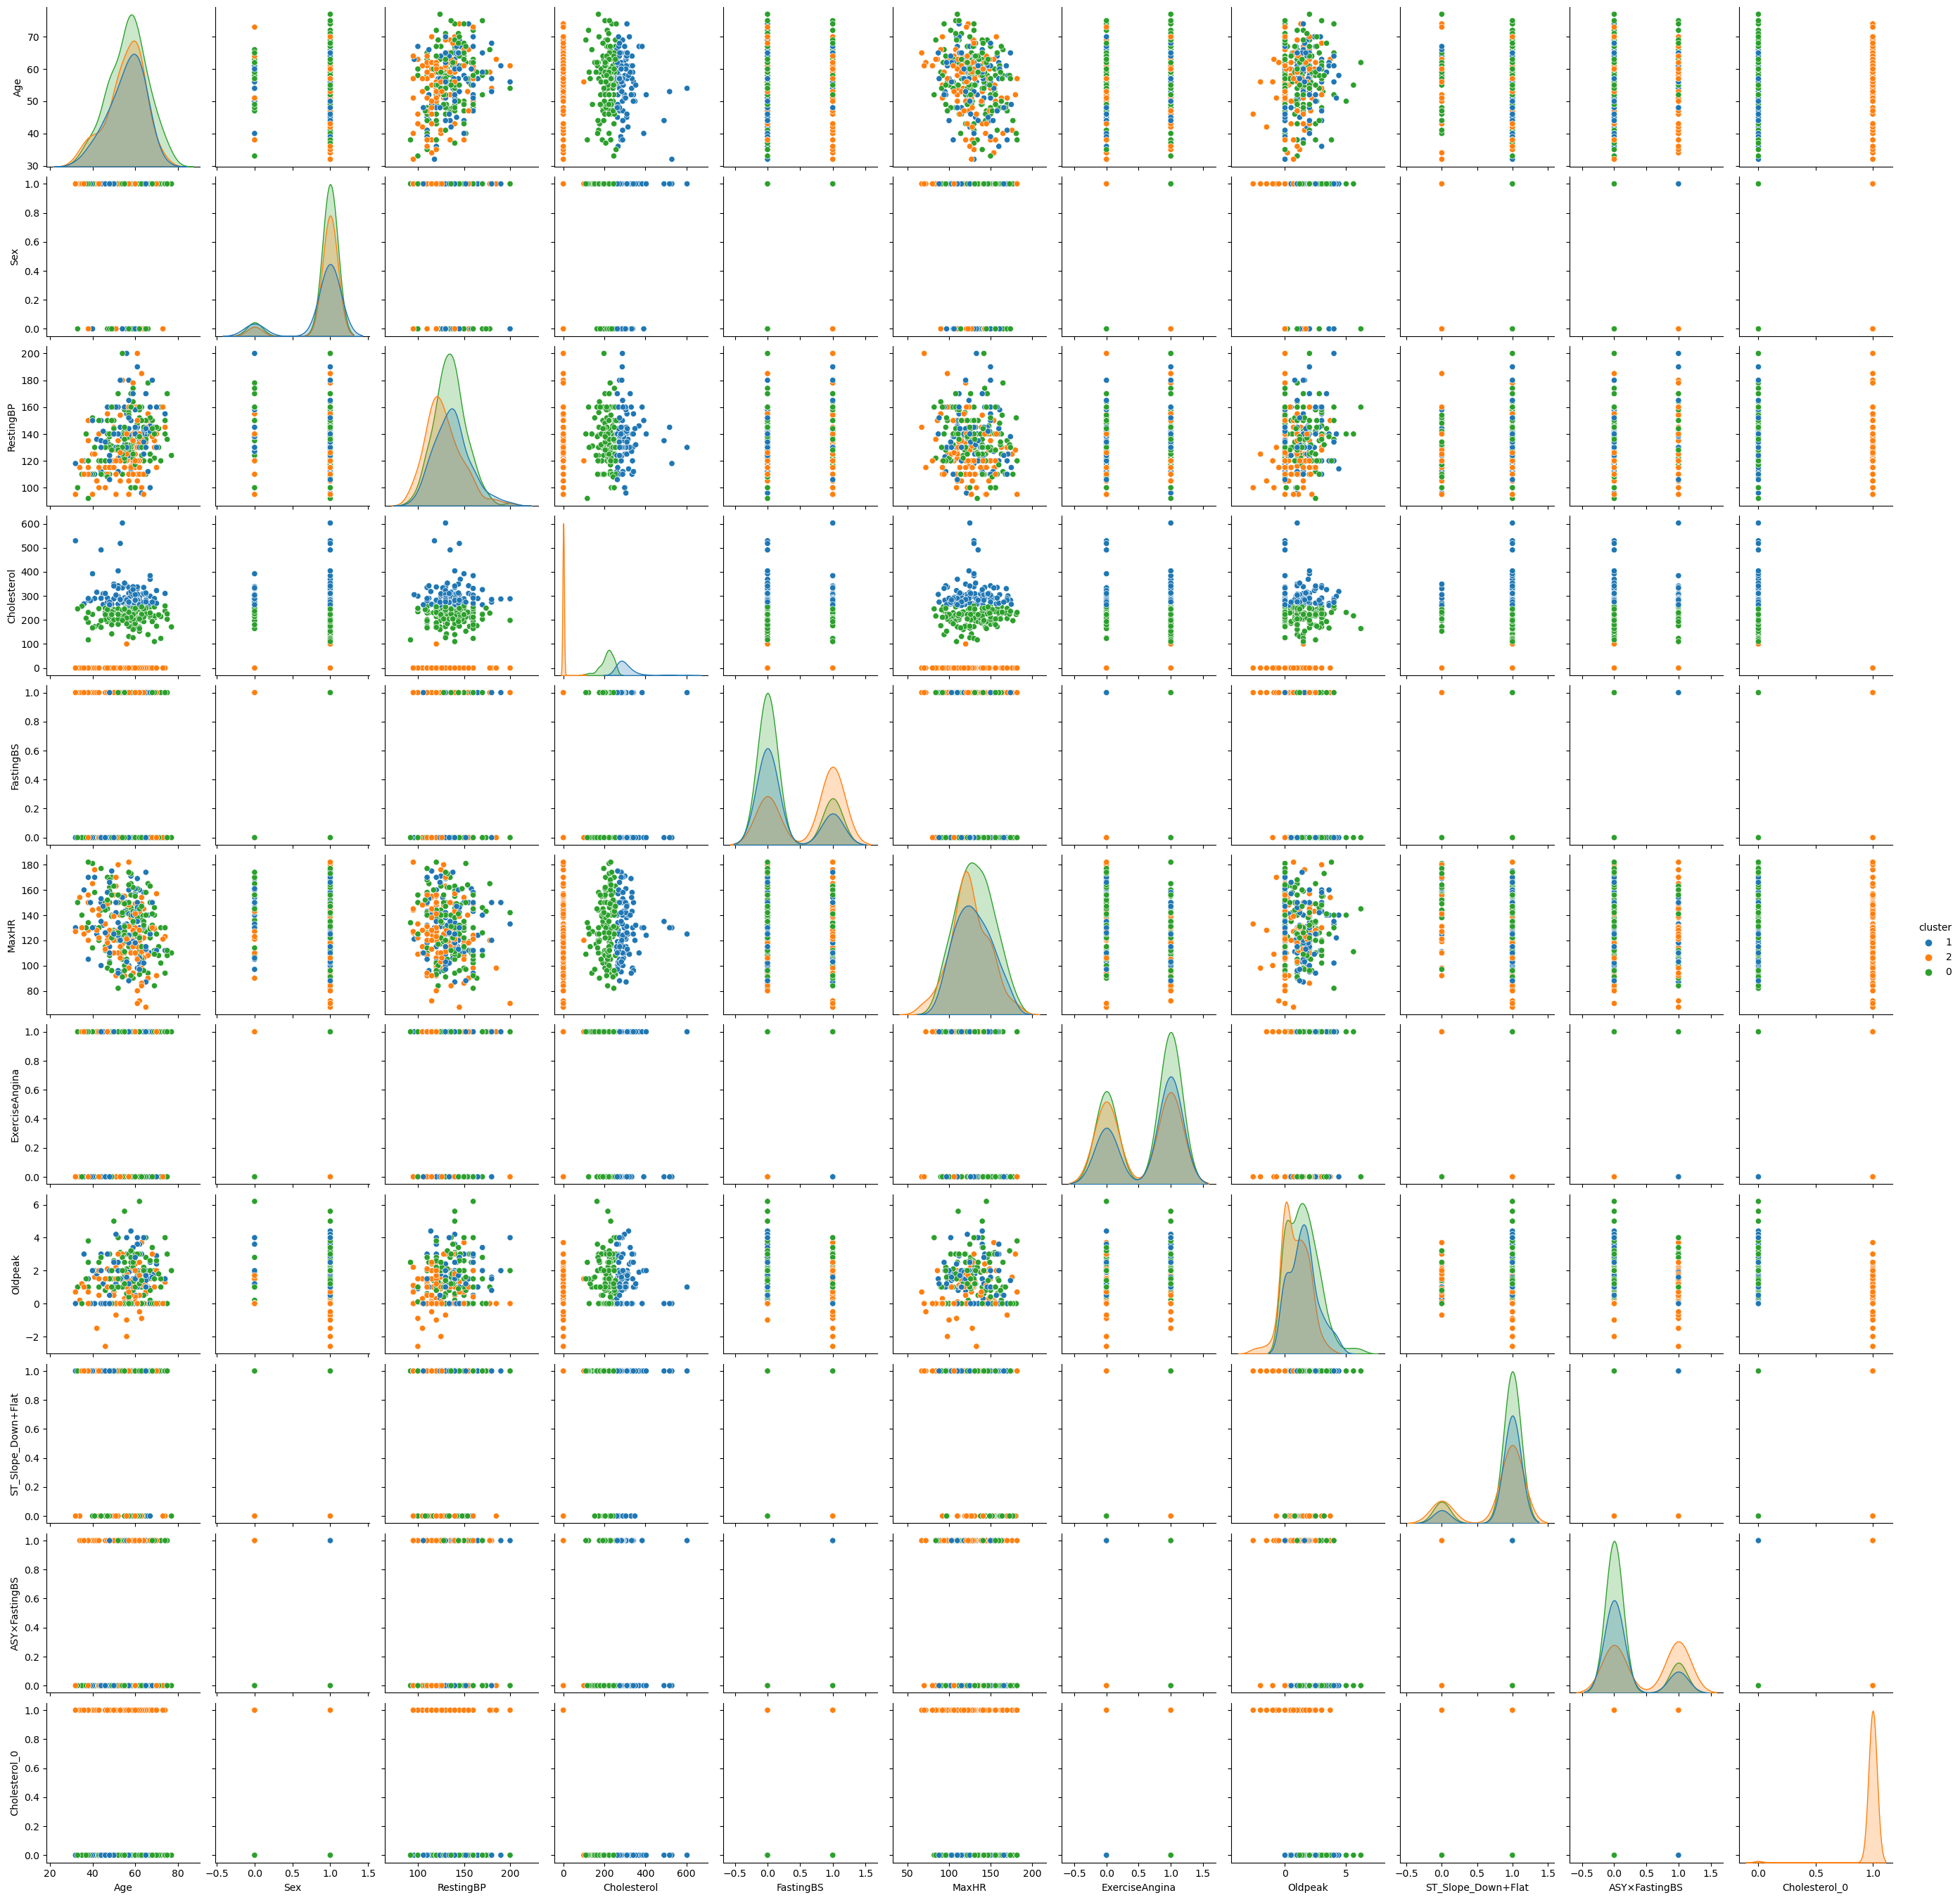

In [101]:
## Chrolestrol == 0 をカラムに追加、 HeartDisease == 1 のみに絞る
data_copy4 = data.copy()
data_copy4 = pd.get_dummies(data_copy4)

data_copy4["ASY×FastingBS"]      = data_copy4["ChestPainType_ASY"] * data_copy4["FastingBS"]
data_copy4["ST_Slope_Down+Flat"] = data_copy4["ST_Slope_Down"] + data_copy4["ST_Slope_Flat"]    

data_copy4["Cholesterol_0"] = data_copy3["Cholesterol"].copy()
data_copy4.loc[data_copy4["Cholesterol_0"] == 0, "Cholesterol_0"] = -1
data_copy4.loc[data_copy4["Cholesterol_0"] != -1, "Cholesterol_0"] = 0
data_copy4.loc[data_copy4["Cholesterol_0"] == -1, "Cholesterol_0"] = 1
data_copy4.head()

km = KMeans(n_clusters = 3)
km.fit(data_copy4.loc[data_copy4["HeartDisease"] == 1])


cluster = km.predict(data_copy4.loc[data_copy4["HeartDisease"] == 1])
data_copy4_heardisease_1 = data_copy4.loc[data_copy4["HeartDisease"] == 1]

data_copy4_heardisease_1 = data_copy4_heardisease_1.assign(cluster = cluster)
data_copy4_heardisease_1["cluster"] = data_copy4_heardisease_1["cluster"].astype("str")

sns.pairplot(data_copy4_heardisease_1[column6_kmean_cluster], hue="cluster")
plt.show()


In [102]:
data_copy4_heardisease_1["Cholesterol_0"].unique()

array([0, 1], dtype=int64)